# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

Text8 Dataset: 31.4MB [00:37, 829kB/s]                             


C:\Users\spark\Desktop\text8>head text8
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institutions anarchists advocate social relations based upon voluntary association of autonomous individuals mutual aid and self governance while anarchism is most easily defined by what it is against anarchists also offer positive visions of what they believe to be a truly free society however ideas about how an anarchist society might work vary considerably especially with respect to economics there is also disagreement about how a free society might be brought about origins and predecessors kropotkin and others argue that before recorded history human society was organized on anarchist principles most anthropologists follow kropotkin and engels in believing that hunter gatherer bands were egalitarian and lacked division of labour accumulated wealth or decreed law and had equal access to resources william godwin anarchists including the the anarchy organisation and rothbard find anarchist attitudes in taoism from ancient china kropotkin found similar ideas in stoic zeno of citium according to kropotkin zeno repudiated the omnipotence of the state its intervention and regimentation and proclaimed the sovereignty of the moral law of the individual the anabaptists of one six th century europe are sometimes considered to be religious forerunners of modern anarchism bertrand russell in his history of western philosophy writes that the anabaptists repudiated all law since they held that the good man will be guided at every moment by the holy spirit from this premise they arrive at communism the diggers or true levellers were an early communistic movement during the time of the english civil war and are considered by some as forerunners of modern anarchism in the modern era the first to use the term to mean something other than chaos was louis armand baron de lahontan in his nouveaux voyages dans l am rique septentrionale one seven zero three where he described the indigenous american society which had no state laws prisons priests or private property as being in anarchy russell means a libertarian and leader in the american indian movement has repeatedly stated that he is an anarchist and so are all his ancestors in one seven nine three in the thick of the french revolution william godwin published an enquiry concerning political justice although godwin did not use the word anarchism many later anarchists have regarded this book as the first major anarchist text and godwin as the founder of philosophical anarchism but at this point no anarchist movement yet existed and the term anarchiste was known mainly as an insult hurled by the bourgeois girondins at more radical elements in the french revolution the first self labelled anarchist pierre joseph proudhon it is commonly held that it wasn t until pierre joseph proudhon published what is property in one eight four zero that the term anarchist was adopted as a self description it is for this reason that some claim proudhon as the founder of modern anarchist theory in what is property proudhon answers with the famous accusation property is theft in this work he opposed the institution of decreed property propri t where owners have complete rights to use and abuse their property as they wish such as exploiting workers for profit in its place proudhon supported what he called possession individuals can have limited rights to use resources capital and goods in accordance with principles of equality and justice proudhon s vision of anarchy which he called mutualism mutuellisme involved an exchange economy where individuals and groups could trade the products of their labor using labor notes which represented the amount of working time involved in production this would ensure that no one would profit from the labor of others workers could freely join together in co operative workshops an interest free bank would be set up to provide everyone with access to the means of production proudhon s ideas were influential within french working class movements and his followers were active in the revolution of one eight four eight in france proudhon s philosophy of property is complex it was developed in a number of works over his lifetime and there are differing interpretations of some of his ideas for more detailed discussion see here max stirner s egoism in his the ego and its own stirner argued that most commonly accepted social institutions including the notion of state property as a right natural rights in general and the very notion of society were mere illusions or ghosts in the mind saying of society that the individuals are its reality he advocated egoism and a form of amoralism in which individuals would unite in associations of egoists only when it was in their self interest to do so for him property simply comes about through might whoever knows how to take to defend the thing to him belongs property and what i have in my power that is my own so long as i assert myself as holder i am the proprietor of the thing stirner never called himself an anarchist he accepted only the label egoist nevertheless his ideas were influential on many individualistically inclined anarchists although interpretations of his thought are diverse american individualist anarchism benjamin tucker in one eight two five josiah warren had participated in a communitarian experiment headed by robert owen called new harmony which failed in a few years amidst much internal conflict warren blamed the community s failure on a lack of individual sovereignty and a lack of private property warren proceeded to organise experimenal anarchist communities which respected what he called the sovereignty of the individual at utopia and modern times in one eight three three warren wrote and published the peaceful revolutionist which some have noted to be the first anarchist periodical ever published benjamin tucker says that warren was the first man to expound and formulate the doctrine now known as anarchism liberty xiv december one nine zero zero one benjamin tucker became interested in anarchism through meeting josiah warren and william b greene he edited and published liberty from august one eight eight one to april one nine zero eight it is widely considered to be the finest individualist anarchist periodical ever issued in the english language tucker s conception of individualist anarchism incorporated the ideas of a variety of theorists greene s ideas on mutual banking warren s ideas on cost as the limit of price a heterodox variety of labour theory of value proudhon s market anarchism max stirner s egoism and herbert spencer s law of equal freedom tucker strongly supported the individual s right to own the product of his or her labour as private property and believed in a market economy for trading this property he argued that in a truly free market system without the state the abundance of competition would eliminate profits and ensure that all workers received the full value of their labor other one nine th century individualists included lysander spooner stephen pearl andrews and victor yarros the first international mikhail bakunin one eight one four one eight seven six in europe harsh reaction followed the revolutions of one eight four eight twenty years later in one eight six four the international workingmen s association sometimes called the first international united some diverse european revolutionary currents including anarchism due to its genuine links to active workers movements the international became signficiant from the start karl marx was a leading figure in the international he was elected to every succeeding general council of the association the first objections to marx came from the mutualists who opposed communism and statism shortly after mikhail bakunin and his followers joined in one eight six eight the first international became polarised into two camps with marx and bakunin as their respective figureheads the clearest difference between the camps was over strategy the anarchists around bakunin favoured in kropotkin s words direct economical struggle against capitalism without interfering in the political parliamentary agitation at that time marx and his followers focused on parliamentary activity bakunin characterised marx s ideas as authoritarian and predicted that if a marxist party gained to power its leaders would end up as bad as the ruling class they had fought against in one eight seven two the conflict climaxed with a final split between the two groups at the hague congress this is often cited as the origin of the conflict between anarchists and marxists from this moment the social democratic and libertarian currents of socialism had distinct organisations including rival internationals anarchist communism peter kropotkin proudhon and bakunin both opposed communism associating it with statism however in the one eight seven zero s many anarchists moved away from bakunin s economic thinking called collectivism and embraced communist concepts communists believed the means of production should be owned collectively and that goods be distributed by need not labor an early anarchist communist was joseph d jacque the first person to describe himself as libertarian unlike proudhon he argued that it is not the product of his or her labor that the worker has a right to but to the satisfaction of his or her needs whatever may be their nature he announced his ideas in his us published journal le libertaire one eight five eight one eight six one peter kropotkin often seen as the most important theorist outlined his economic ideas in the conquest of bread and fields factories and workshops he felt co operation is more beneficial than competition illustrated in nature in mutual aid a factor of evolution one eight nine seven subsequent anarchist communists include emma goldman and alexander berkman many in the anarcho syndicalist movements see below saw anarchist communism as their objective isaac puente s one nine three two comunismo libertario was adopted by the spanish cnt as its manifesto for a post revolutionary society some anarchists disliked merging communism with anarchism several individualist anarchists maintained that abolition of private property was not consistent with liberty for example benjamin tucker whilst professing respect for kropotkin and publishing his work described communist anarchism as pseudo anarchism propaganda of the deed johann most was an outspoken advocate of violence anarchists have often been portrayed as dangerous and violent due mainly to a number of high profile violent acts including riots assassinations insurrections and terrorism by some anarchists some revolutionaries of the late one nine th century encouraged acts of political violence such as bombings and the assassinations of heads of state to further anarchism such actions have sometimes been called propaganda by the deed one of the more outspoken advocates of this strategy was johann most who said the existing system will be quickest and most radically overthrown by the annihilation of its exponents therefore massacres of the enemies of the people must be set in motion most s preferred method of terrorism dynamite earned him the moniker dynamost however there is no consensus on the legitimacy or utility of violence in general mikhail bakunin and errico malatesta for example wrote of violence as a necessary and sometimes desirable force in revolutionary settings but at the same time they denounced acts of individual terrorism malatesta in on violence and bakunin when he refuted nechaev other anarchists sometimes identified as pacifist anarchists advocated complete nonviolence leo tolstoy whose philosophy is often viewed as a form of christian anarchism see below was a notable exponent of nonviolent resistance anarchism in the labour movement the red and black flag coming from the experience of anarchists in the labour movement is particularly associated with anarcho syndicalism anarcho syndicalism was an early two zero th century working class movement seeking to overthrow capitalism and the state to institute a worker controlled society the movement pursued industrial actions such as general strike as a primary strategy many anarcho syndicalists believed in anarchist communism though not all communists believed in syndicalism after the one eight seven one repression french anarchism reemerged influencing the bourses de travails of autonomous workers groups and trade unions from this movement the conf d ration g n rale du travail general confederation of work cgt was formed in one eight nine five as the first major anarcho syndicalist movement emile pataud and emile pouget s writing for the cgt saw libertarian communism developing from a general strike after one nine one four the cgt moved away from anarcho syndicalism due to the appeal of bolshevism french style syndicalism was a significant movement in europe prior to one nine two one and remained a significant movement in spain until the mid one nine four zero s the industrial workers of the world iww founded in one nine zero five in the us espoused unionism and sought a general strike to usher in a stateless society in one nine two three one zero zero zero zero zero members existed with the support of up to three zero zero zero zero zero though not explicitly anarchist they organized by rank and file democracy embodying a spirit of resistance that has inspired many anglophone syndicalists cnt propaganda from april two zero zero four reads don t let the politicians rule our lives you vote and they decide don t allow it unity action self management spanish anarchist trade union federations were formed in the one eight seven zero s one nine zero zero and one nine one zero the most successful was the confederaci n nacional del trabajo national confederation of labour cnt founded in one nine one zero prior to the one nine four zero s the cnt was the major force in spanish working class politics with a membership of one five eight million in one nine three four the cnt played a major role in the spanish civil war see also anarchism in spain syndicalists like ricardo flores mag n were key figures in the mexican revolution latin american anarchism was strongly influenced extending to the zapatista rebellion and the factory occupation movements in argentina in berlin in one nine two two the cnt was joined with the international workers association an anarcho syndicalist successor to the first international contemporary anarcho syndicalism continues as a minor force in many socities much smaller than in the one nine one zero s two zero s and three zero s the largest organised anarchist movement today is in spain in the form of the confederaci n general del trabajo and the cnt the cgt claims a paid up membership of six zero zero zero zero and received over a million votes in spanish syndical elections other active syndicalist movements include the us workers solidarity alliance and the uk solidarity federation the revolutionary industrial unionist industrial workers of the world also exists claiming two zero zero zero paid members contemporary critics of anarcho syndicalism and revolutionary industrial unionism claim that they are workerist and fail to deal with economic life outside work post leftist critics such as bob black claim anarcho syndicalism advocates oppressive social structures such as work and the workplace anarcho syndicalists in general uphold principles of workers solidarity direct action and self management the russian revolution the russian revolution of one nine one seven was a seismic event in the development of anarchism as a movement and as a philosophy anarchists participated alongside the bolsheviks in both february and october revolutions many anarchists initially supporting the bolshevik coup however the bolsheviks soon turned against the anarchists and other left wing opposition a conflict which culminated in the one nine one eight kronstadt rebellion anarchists in central russia were imprisoned or driven underground or joined the victorious bolsheviks in ukraine anarchists fought in the civil war against both whites and bolsheviks within the makhnovshchina peasant army led by nestor makhno expelled american anarchists emma goldman and alexander berkman before leaving russia were amongst those agitating in response to bolshevik policy and the suppression of the kronstadt uprising both wrote classic accounts of their experiences in russia aiming to expose the reality of bolshevik control for them bakunin s predictions about the consequences of marxist rule had proved all too true the victory of the bolsheviks in the october revolution and the resulting russian civil war did serious damage to anarchist movements internationally many workers and activists saw bolshevik success as setting an example communist parties grew at the expense of anarchism and other socialist movements in france and the us for example the major syndicalist movements of the cgt and iww began to realign themselves away from anarchism and towards the communist international in paris the dielo truda group of russian anarchist exiles which included nestor makhno concluded that anarchists needed to develop new forms of organisation in response to the structures of bolshevism their one nine two six manifesto known as the organisational platform of the libertarian communists was supported by some communist anarchists though opposed by many others the platform continues to inspire some contemporary anarchist groups who believe in an anarchist movement organised around its principles of theoretical unity tactical unity collective responsibility and federalism platformist groups today include the workers solidarity movement in ireland the uk s anarchist federation and the late north eastern federation of anarchist communists in the northeastern united states and bordering canada the fight against fascism spain one nine three six members of the cnt construct armoured cars to fight against the fascists in one of the collectivised factories in the one nine two zero s and one nine three zero s the familiar dynamics of anarchism s conflict with the state were transformed by the rise of fascism in europe in many cases european anarchists faced difficult choices should they join in popular fronts with reformist democrats and soviet led communists against a common fascist enemy luigi fabbri an exile from italian fascism was amongst those arguing that fascism was something different fascism is not just another form of government which like all others uses violence it is the most authoritarian and the most violent form of government imaginable it represents the utmost glorification of the theory and practice of the principle of authority in france where the fascists came close to insurrection in the february one nine three four riots anarchists divided over a united front policy in spain the cnt initially refused to join a popular front electoral alliance and abstention by cnt supporters led to a right wing election victory but in one nine three six the cnt changed its policy and anarchist votes helped bring the popular front back to power months later the ruling class responded with an attempted coup and the spanish civil war one nine three six three nine was underway in reponse to the army rebellion an anarchist inspired movement of peasants and workers supported by armed militias took control of the major city of barcelona and of large areas of rural spain where they collectivized the land but even before the eventual fascist victory in one nine three nine the anarchists were losing ground in a bitter struggle with the stalinists the cnt leadership often appeared confused and divided with some members controversially entering the government stalinist led troops suppressed the collectives and persecuted both dissident marxists and anarchists since the late one nine seven zero s anarchists have been involved in fighting the rise of neo fascist groups in germany and the united kingdom some anarchists worked within militant anti fascist groups alongside members of the marxist left they advocated directly combating fascists with physical force rather than relying on the state since the late one nine nine zero s a similar tendency has developed within us anarchism see also anti racist action us anti fascist action uk antifa religious anarchism leo tolstoy one eight two eight one nine one zero most anarchist culture tends to be secular if not outright anti religious however the combination of religious social conscience historical religiousity amongst oppressed social classes and the compatibility of some interpretations of religious traditions with anarchism has resulted in religious anarchism christian anarchists believe that there is no higher authority than god and oppose earthly authority such as government and established churches they believe that jesus teachings were clearly anarchistic but were corrupted when christianity was declared the official religion of rome christian anarchists who follow jesus directive to turn the other cheek are strict pacifists the most famous advocate of christian anarchism was leo tolstoy author of the kingdom of god is within you who called for a society based on compassion nonviolent principles and freedom christian anarchists tend to form experimental communities they also occasionally resist taxation many christian anarchists are vegetarian or vegan christian anarchy can be said to have roots as old as the religion s birth as the early church exhibits many anarchistic tendencies such as communal goods and wealth by aiming to obey utterly certain of the bible s teachings certain anabaptist groups of sixteenth century europe attempted to emulate the early church s social economic organisation and philosophy by regarding it as the only social structure capable of true obediance to jesus teachings and utterly rejected in theory all earthly hierarchies and authority and indeed non anabaptists in general and violence as ungodly such groups for example the hutterites typically went from initially anarchistic beginnings to as their movements stabalised more authoritarian social models chinese anarchism was most influential in the one nine two zero s strands of chinese anarchism included tai xu s buddhist anarchism which was influenced by tolstoy and the well field system neopaganism with its focus on the environment and equality along with its often decentralized nature has lead to a number of neopagan anarchists one of the most prominent is starhawk who writes extensively about both spirituality and activism anarchism and feminism emma 

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [14]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [15]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [16]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.7002 0.2136 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6626 0.2151 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5030 0.2155 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5838 0.2136 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.4836 0.2139 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5422 0.2128 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5689 0.2127 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5487 0.2124 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4614 0.2140 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4154 0.2123 sec/batch
Nearest to if: catering, jespersen, tupi, msp, boots, paired, sampled, dumpling,
Nearest to during: webmaster, wes, octahedron, nullification, fridtjof, module, vaduz, grainger,
Nearest to is: tenor, amathus, dm, swiftness, forward, restart, krantz, furthest,
Nearest to has: gentle, utilizing, lans

Restore the trained network if you need to:

In [17]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/ubuntu/anaconda3/envs/word2vec/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/word2vec/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [19]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

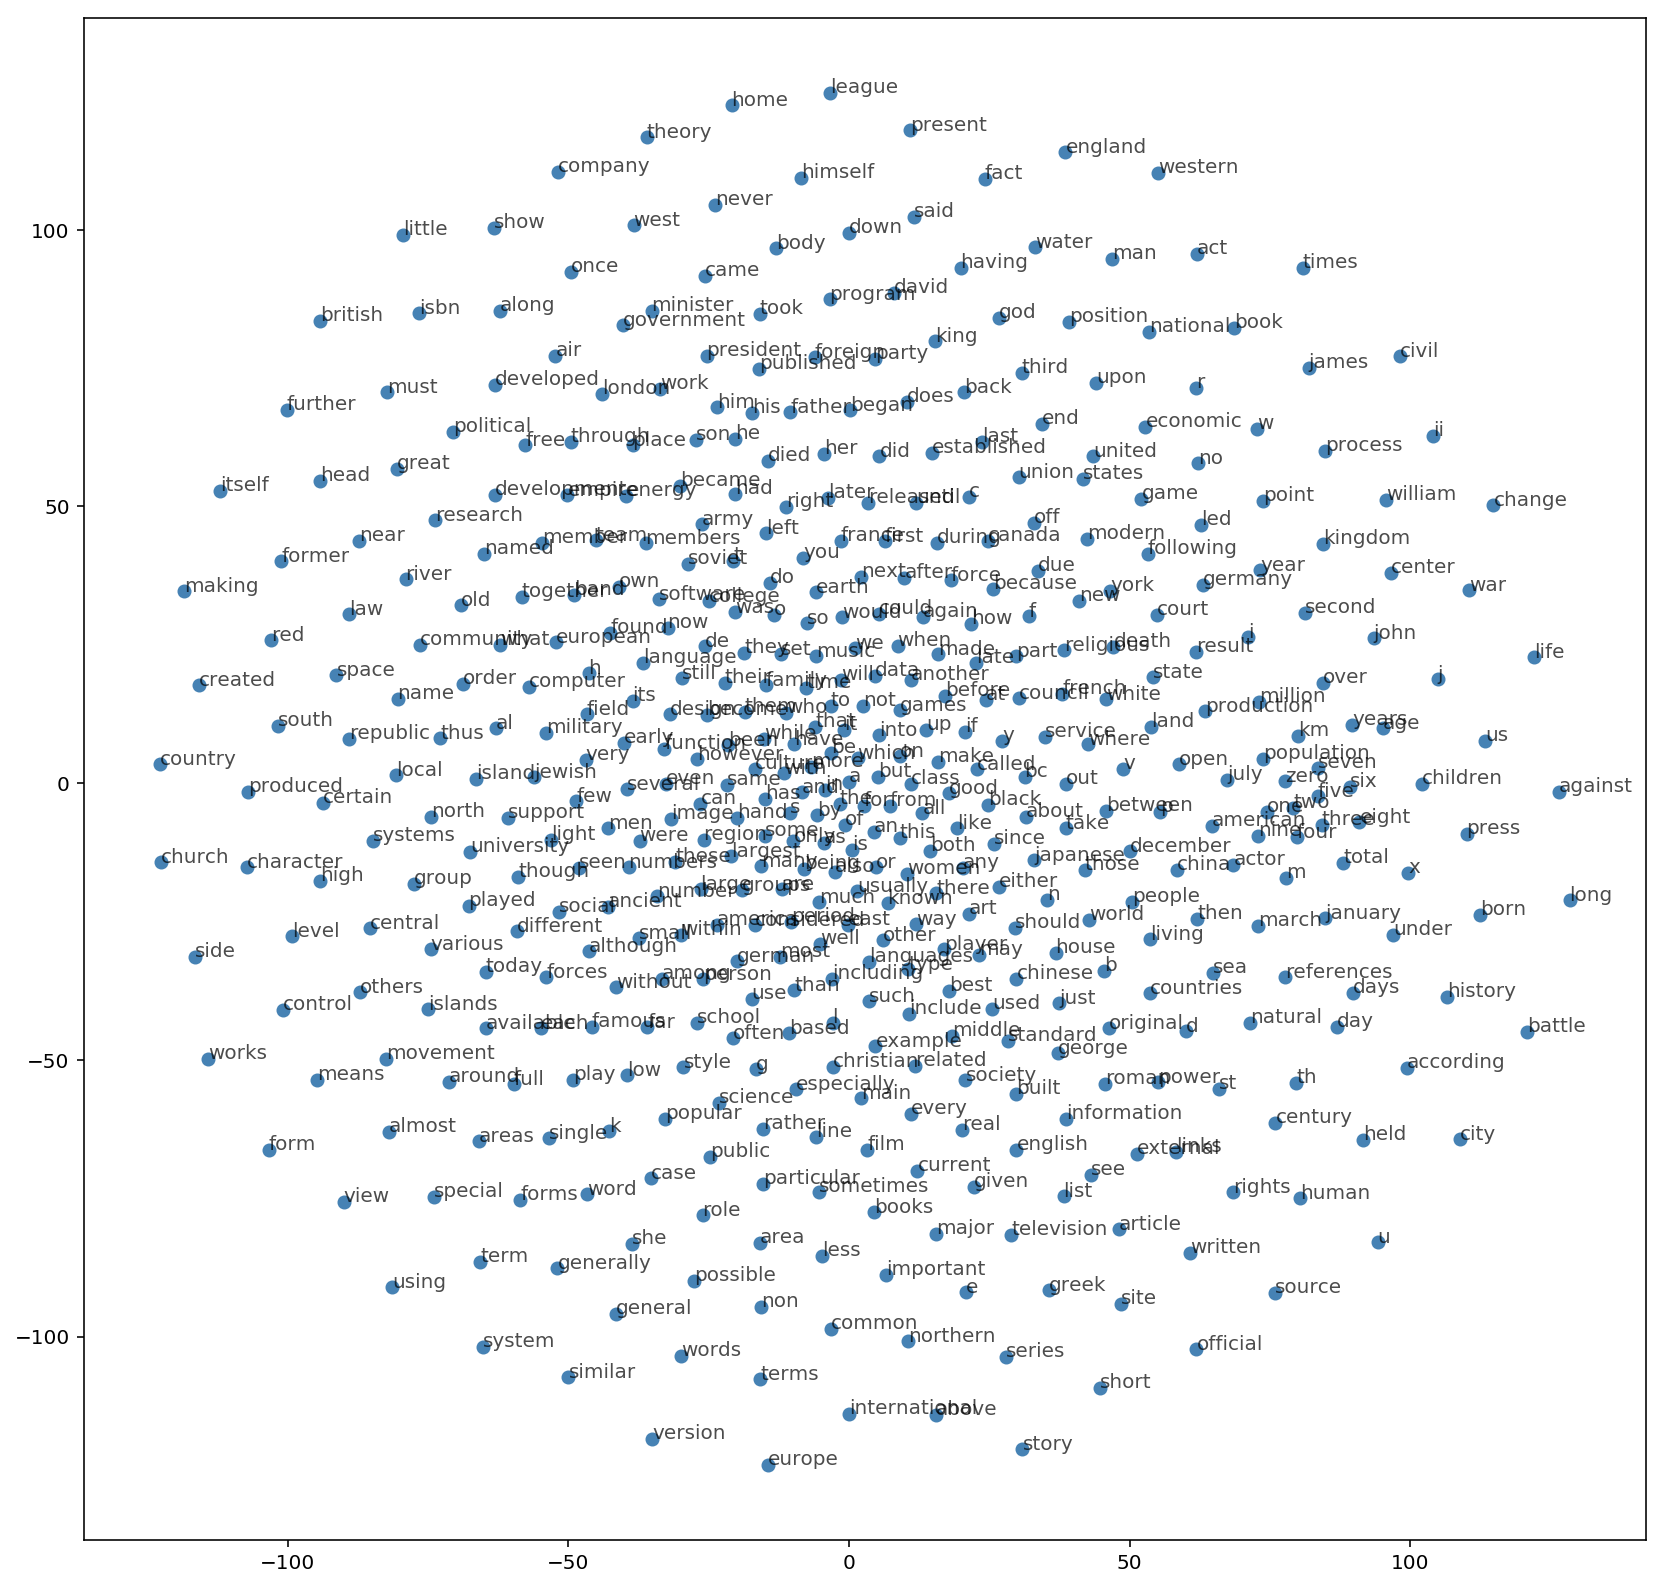

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)